In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

assert tf.__version__ == '1.3.0'

%matplotlib inline

Let's create samle array

200000


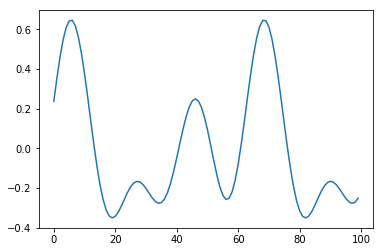

In [2]:

i = 2000
a1 = np.arange(0,10*i*1,.1)
a2 = np.arange(0,10*i*2,.2)
a3 = np.arange(0,10*i*3,.3)

array = np.cos(a1) + np.sin(a2) + np.sin(a3)
array = (array - array.mean())/(array.max() - array.min())
plt.plot(array[:100])
print(len(array))
plt.show()

As our array of samples is a function, we could just use just the function to create batches. But lets pretend we have some fixed-lenght timeseries. It will ease reusing code later if needed

In [3]:
def get_batch(array, batch_size=10, min_source_length=200, max_source_length=400, time_to_predict=65):
    """
    :param array: timeseries data
    :param batch_size: size of the batch
    :param min_source_length: min lenght of the sample
    :param max_source_length: max lenght of the sample
    :param time_to_predict: timeticks we ned to predict
    :return: X[batch_size, len, 1], y[batch_size, time_to_predict]
            where N is random between min_source_length and max_source_length
    """
    source_len = np.int32(
        np.random.uniform(
            min_source_length + time_to_predict,
            max_source_length + time_to_predict,
        )
    )
    start_range = 0
    end_range = array.shape[0] - time_to_predict - source_len
    idxes = np.int32(
        np.random.uniform(
            start_range, end_range,
            size=batch_size
        )
    )
    out = np.vstack([array[i:i+source_len] for i in idxes])
    return out[:, :-time_to_predict, np.newaxis], out[:, -time_to_predict:]

tmp = get_batch(array)
tmp[0].shape, tmp[1].shape

((10, 315, 1), (10, 65))

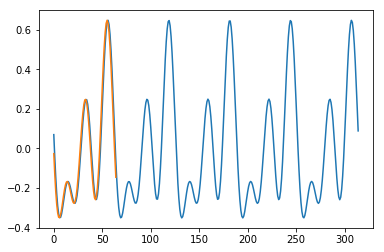

In [4]:
plt.plot(tmp[0][1])
plt.plot(tmp[1][1])

This will be really basic net without any optimisations or tricks.

In [5]:
def decoder(encoder_state, rnn_size, num_layers_decoder, last_value, time_to_predict):
    """
    :param encoder_state: shape [batch_size, encoder_rnn_depth]
    :param last_value: shape [batch_size], last avaliable value
    :return: decoder rnn output
    """
    
    # decoder
    stacked_decoder = []
    for _ in range(num_layers_decoder):
        stacked_decoder.append(
            tf.contrib.rnn.LSTMCell(rnn_size)
        )

    dec_multicell = tf.contrib.rnn.MultiRNNCell(cells=stacked_decoder)
    
    def loop_cond(time, prev_output, prev_decoder_state, array_y):
        return time < time_to_predict
    
    def loop_body(time, prev_output, prev_decoder_state, array_y):
        output, state = dec_multicell(prev_output, prev_decoder_state)
        output = tf.layers.dense(output, 1)
        array_y = array_y.write(time, output)
        return time + 1, output, state, array_y
    
    loop_vars = [
        tf.constant(0, dtype=tf.int32),
        last_value,
        encoder_state,
        tf.TensorArray(dtype=tf.float32, size=time_to_predict),
    ]
    y = tf.while_loop(loop_cond, loop_body, loop_vars)[-1]
    y = y.stack()
    y = tf.squeeze(y, axis=-1)
    return tf.transpose(y)

step: 0, loss: 0.08386467397212982
step: 10, loss: 0.08341942727565765
step: 20, loss: 0.08218738436698914
step: 30, loss: 0.06229090690612793
step: 40, loss: 0.059645023196935654
step: 50, loss: 0.056221283972263336
step: 60, loss: 0.053196560591459274
step: 70, loss: 0.04886563867330551
step: 80, loss: 0.04228343814611435
step: 90, loss: 0.0344964824616909
step: 100, loss: 0.02864624559879303


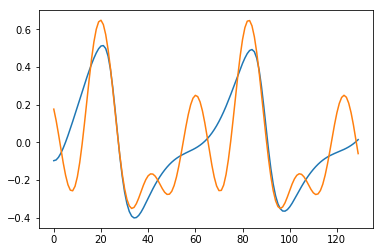

step: 110, loss: 0.025545785203576088
step: 120, loss: 0.02305753342807293
step: 130, loss: 0.02215610444545746
step: 140, loss: 0.020827095955610275
step: 150, loss: 0.019767697900533676
step: 160, loss: 0.018122002482414246
step: 170, loss: 0.016760816797614098
step: 180, loss: 0.01603621430695057
step: 190, loss: 0.014428731985390186
step: 200, loss: 0.012887622229754925


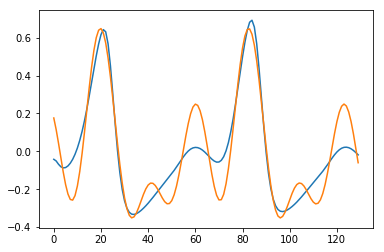

step: 210, loss: 0.011746946722269058
step: 220, loss: 0.018454566597938538
step: 230, loss: 0.01159051712602377
step: 240, loss: 0.010370196774601936
step: 250, loss: 0.00879687536507845
step: 260, loss: 0.007391984108835459
step: 270, loss: 0.0062286220490932465
step: 280, loss: 0.0057016341015696526
step: 290, loss: 0.005472342483699322
step: 300, loss: 0.004820105154067278


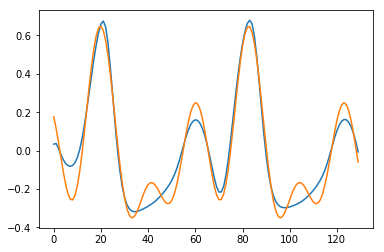

step: 310, loss: 0.004691965412348509
step: 320, loss: 0.004068322479724884
step: 330, loss: 0.003727416507899761
step: 340, loss: 0.004347800277173519
step: 350, loss: 0.008045670576393604
step: 360, loss: 0.0061367591843008995
step: 370, loss: 0.0037957322783768177
step: 380, loss: 0.0035306646022945642
step: 390, loss: 0.003142568515613675
step: 400, loss: 0.0028246412985026836


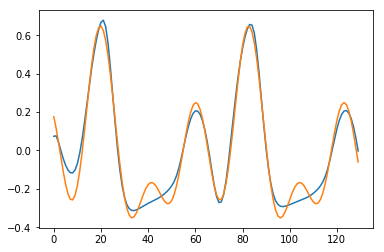

step: 410, loss: 0.002656016731634736
step: 420, loss: 0.0024350008461624384
step: 430, loss: 0.002419477328658104
step: 440, loss: 0.002249323297291994
step: 450, loss: 0.002218259032815695
step: 460, loss: 0.002250875346362591
step: 470, loss: 0.002080542966723442
step: 480, loss: 0.0020636827684938908
step: 490, loss: 0.001953733852133155
step: 500, loss: 0.0019595299381762743


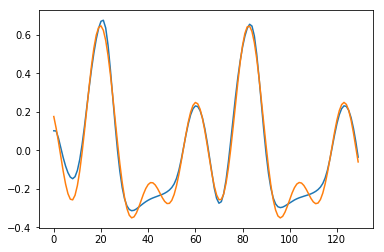

step: 510, loss: 0.0018660458736121655
step: 520, loss: 0.0017877350328490138
step: 530, loss: 0.0016994329635053873
step: 540, loss: 0.0016912511782720685
step: 550, loss: 0.0016338381683453918
step: 560, loss: 0.0015639462508261204
step: 570, loss: 0.0018162443302571774
step: 580, loss: 0.0015428053447976708
step: 590, loss: 0.0015782971167936921
step: 600, loss: 0.0018749276641756296


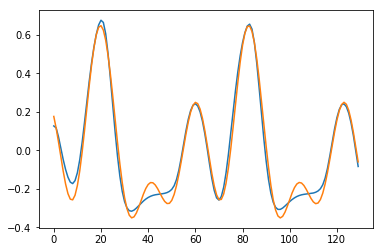

step: 610, loss: 0.0013309777714312077
step: 620, loss: 0.0013953170273452997
step: 630, loss: 0.0013566954294219613
step: 640, loss: 0.001264065271243453
step: 650, loss: 0.0012471210211515427
step: 660, loss: 0.001159805222414434
step: 670, loss: 0.0011247381335124373
step: 680, loss: 0.001135262311436236
step: 690, loss: 0.0012653939193114638
step: 700, loss: 0.0012204478261992335


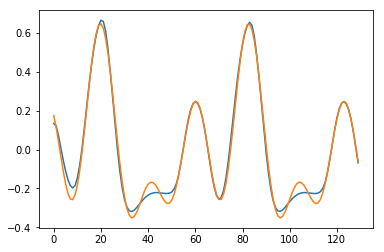

step: 710, loss: 0.0011569455964490771
step: 720, loss: 0.0011760096531361341
step: 730, loss: 0.0010421245824545622
step: 740, loss: 0.0010719021083787084
step: 750, loss: 0.0009187366813421249
step: 760, loss: 0.0009092366090044379
step: 770, loss: 0.0009607990505173802
step: 780, loss: 0.000879802624695003
step: 790, loss: 0.0007926904945634305
step: 800, loss: 0.0008204412297345698


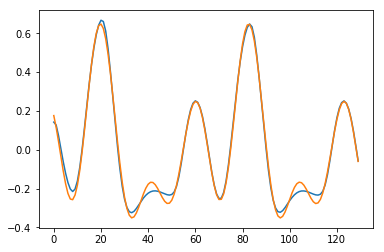

step: 810, loss: 0.0008212477550841868
step: 820, loss: 0.000795247033238411
step: 830, loss: 0.0007542653474956751
step: 840, loss: 0.000697600597050041
step: 850, loss: 0.0006921145832166076
step: 860, loss: 0.0006826265598647296
step: 870, loss: 0.0008101054700091481
step: 880, loss: 0.0009317302610725164
step: 890, loss: 0.0007035410380922258
step: 900, loss: 0.0006731043686158955


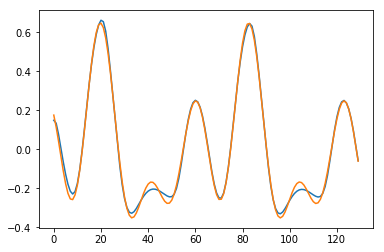

step: 910, loss: 0.000616458069998771
step: 920, loss: 0.0006092378753237426
step: 930, loss: 0.0006158396136015654
step: 940, loss: 0.0005970646161586046
step: 950, loss: 0.0005476944497786462
step: 960, loss: 0.0005734169390052557
step: 970, loss: 0.0005554525414481759
step: 980, loss: 0.000515666208229959
step: 990, loss: 0.0005087328609079123
Final prediction


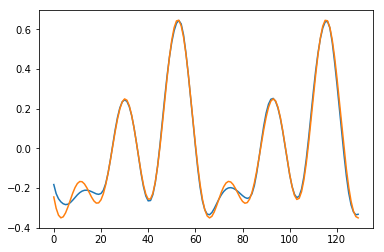

CPU times: user 46min 8s, sys: 6min 4s, total: 52min 13s
Wall time: 24min 13s


In [7]:
%%time

rnn_size=10
num_layers_encoder, num_layers_decoder = 5, 5
min_source_length = 200
max_source_length = 400
batch_size = 200
time_to_predict = 130


train_graph = tf.Graph()
with train_graph.as_default():
    
    inputs = tf.placeholder(tf.float32, [None, None, 1], name="input")
    targets = tf.placeholder(tf.float32, [None, time_to_predict], name="targets")
    lr = tf.placeholder(tf.float32, name="learning_rate")
    
    sequence_length = tf.placeholder_with_default(
        max_source_length, None, name='sequence_length')

    input_shape = tf.shape(inputs)

    # encoder
    stacked_encoder = []
    for _ in range(num_layers_encoder):
        stacked_encoder.append(
            tf.contrib.rnn.LSTMCell(rnn_size)
        )

    enc_multicell = tf.contrib.rnn.MultiRNNCell(cells=stacked_encoder)

    _, encoder_state = tf.nn.dynamic_rnn(
        enc_multicell,
        inputs,
        sequence_length=sequence_length,
        dtype=tf.float32)
    

    predictions = decoder(encoder_state, rnn_size, num_layers_decoder, inputs[:, -1, :], time_to_predict)

    loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    
    optimizer = tf.train.AdamOptimizer()
    
    global_step = tf.Variable(0, name='global_step', trainable=False)
    
    train_op = optimizer.minimize(loss, global_step=global_step)
    
    init = tf.global_variables_initializer()
    
    sess = tf.Session()
    
    summary_writer = tf.summary.FileWriter('./log', sess.graph)
    
    sess.run(init)
    
    X_test = array[np.newaxis, :300, np.newaxis]
    y_test = array[300:300 + time_to_predict]
    X_val = array[np.newaxis, 130:330, np.newaxis]
    y_val = array[330:330 + time_to_predict]
    
    for step in range(1000):
        X_b, y_b = get_batch(
            array, 
            batch_size=batch_size,
            min_source_length=min_source_length,
            max_source_length=max_source_length,
            time_to_predict=time_to_predict)
        
        feed_dict = {
            inputs: X_b,
            targets: y_b
        }
        _, loss_value = sess.run([train_op, loss],
                               feed_dict=feed_dict)
        
        if step % 10 == 0:
            print("step: {}, loss: {}".format(step,loss_value))
            
            
        if (step > 0) and (step % 100 == 0):
            test_preds = sess.run(predictions, feed_dict={inputs: X_test})
            plt.plot(test_preds[0])
            plt.plot(y_test)
            plt.show()
    
    
    val_preds = sess.run(predictions, feed_dict={inputs: X_val})

    
print("Final prediction")
plt.plot(val_preds[0])
plt.plot(y_val)
plt.show()